In [2]:
# importing the libraries
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
from akapriori import apriori
import armine
import networkx as nx
import hashlib

# loading the datasets
orders_all = pd.read_csv("orders.csv",index_col=None,header=0)
orders_prod_p=pd.read_csv("order_products__prior.csv",index_col=None,header=0)
orders_prod_t=pd.read_csv("order_products__train.csv",index_col=None,header=0)
products=pd.read_csv("products.csv",index_col=None,header=0)
dept=pd.read_csv("departments.csv",index_col=None,header=0)
aisles=pd.read_csv("aisles.csv",index_col=None,header=0)
orders_prod_p=orders_prod_p.append(orders_prod_t)


# merging datasets to create single transaction file
orders_prod_norm=orders_prod_t.merge(orders_all,on="order_id")
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")

orders_prod_norm["product_id_str"]=orders_prod_norm["product_id"].astype(str)

# building apriori
g=orders_prod_norm.groupby("order_id")["product_name"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["prod_list"]=g2.apply(lambda x: tuple(x["product_name"].split(",")),axis=1)

#creating a list of lists
rules = apriori(list(g2["prod_list"]), support=0.001, confidence=0.25, lift=1.0)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC
rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])

df_rules=pd.DataFrame(rules_list)
df_rules.columns=["Antecedent","Consequent","Support","Confidence","Lift"]

df_rules.head(10)

,Antecedent,Consequent,Support,Confidence,Lift
0,Strawberry Rhubarb Yoghurt,Blueberry Yoghurt,0.001197,0.309665,80.298014
1,Blueberry Yoghurt,Strawberry Rhubarb Yoghurt,0.001197,0.310277,80.298014
2,Nonfat Icelandic Style Strawberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.001166,0.422652,78.660621
3,Non Fat Acai & Mixed Berries Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.001288,0.402381,74.887947
4,Blackberry Cucumber Sparkling Water,Kiwi Sandia Sparkling Water,0.001014,0.256757,72.449026
5,Kiwi Sandia Sparkling Water,Blackberry Cucumber Sparkling Water,0.001014,0.286022,72.449026
6,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.001677,0.381944,71.084466
7,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.001677,0.312057,71.084466
8,Lemon Sparkling Water,Grapefruit Sparkling Water,0.001097,0.313043,65.197019
9,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% Lowfat Greek Strained Yogurt with Peach,0.001364,0.276662,56.367206


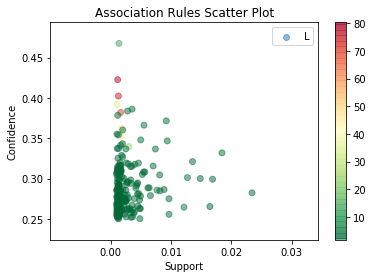

In [3]:
#Association rule scatterplot
x = np.array(df_rules['Support'])
y = np.array(df_rules['Confidence'])
colors = np.array(df_rules['Lift'])

plt.scatter(x, y, c=colors, cmap='RdYlGn_r',alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend('Lift')
plt.title('Association Rules Scatter Plot')
plt.colorbar()
plt.show()

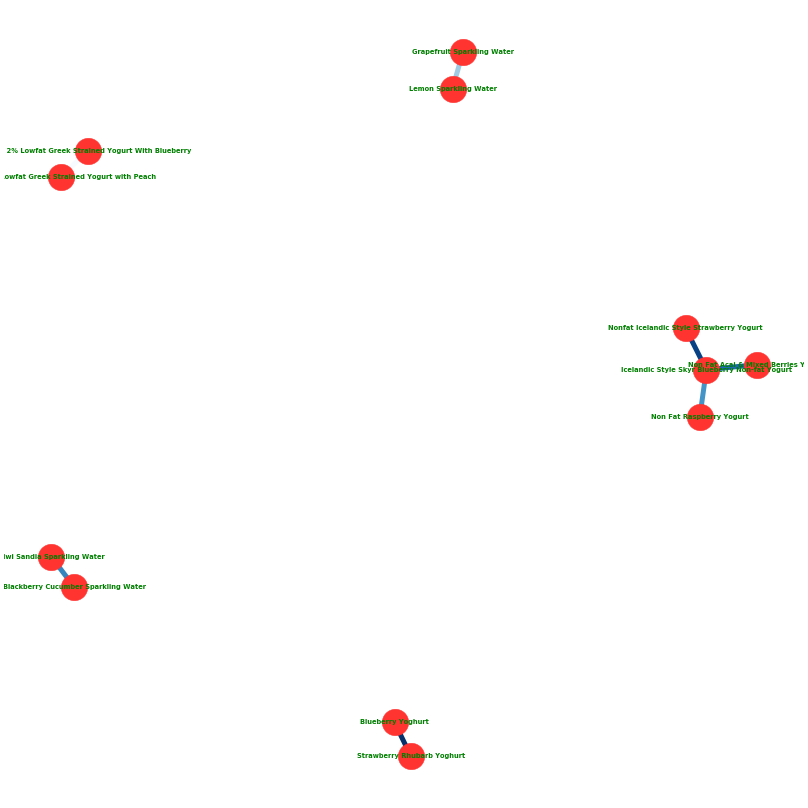

In [5]:
# Association Rules Graph
G=nx.from_pandas_edgelist(df_rules.head(10),"Antecedent","Consequent","Lift")
my_dpi=40
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw(G,with_labels=True,node_color="#ff3330",node_size=2250,edge_color=colors, arrows=False,font_color="Green",font_weight="bold",font_size=12,style="solid",width=9,edge_cmap=plt.cm.Blues)

plt.savefig("nx.png",format="png" )
plt.show()

In [6]:
# Top 10 Marketing Insights of Association by Products on Lift

df_rules_by_lift=pd.DataFrame("People who usually buy "+ '<b>' + "{" + df_rules.head(10)['Antecedent'].astype(str) + "}" +'</b>'+" also buy "+'<b>' + "{" + df_rules.head(10)['Consequent'].astype(str) + "}" +'</b>')
pd.set_option("expand_frame_repr", True)
df_rules_by_lift.columns=["Marketing Insights"]

left_aligned_df_lift = df_rules_by_lift.style.set_properties(**{'text-align': 'left'})
left_aligned_df_lift = left_aligned_df_lift.set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_df_lift)


,Marketing Insights
0,People who usually buy {Strawberry Rhubarb Yoghurt} also buy {Blueberry Yoghurt}
1,People who usually buy {Blueberry Yoghurt} also buy {Strawberry Rhubarb Yoghurt}
2,People who usually buy {Nonfat Icelandic Style Strawberry Yogurt} also buy {Icelandic Style Skyr Blueberry Non-fat Yogurt}
3,People who usually buy {Non Fat Acai & Mixed Berries Yogurt} also buy {Icelandic Style Skyr Blueberry Non-fat Yogurt}
4,People who usually buy {Blackberry Cucumber Sparkling Water} also buy {Kiwi Sandia Sparkling Water}
5,People who usually buy {Kiwi Sandia Sparkling Water} also buy {Blackberry Cucumber Sparkling Water}
6,People who usually buy {Non Fat Raspberry Yogurt} also buy {Icelandic Style Skyr Blueberry Non-fat Yogurt}
7,People who usually buy {Icelandic Style Skyr Blueberry Non-fat Yogurt} also buy {Non Fat Raspberry Yogurt}
8,People who usually buy {Lemon Sparkling Water} also buy {Grapefruit Sparkling Water}
9,People who usually buy {Total 2% Lowfat Greek Strained Yogurt With Blueberry} also buy {Total 2% Lowfat Greek Strained Yogurt with Peach}
